In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

In [2]:
gdf = gpd.read_file("all_states_precincts_cname_neighbor_demo_OG.json")

In [3]:
def parseNeighbors(gdf, centerCname):
    neighbors = gdf[gdf["CName"] == centerCname]["Neighbors"].iloc[-1].split(";")
    if neighbors[0] == "":
        return ""
    else:
        neighbors = [n.strip().split(",")[1] for n in neighbors]
        return neighbors
    
    
def P1ContainsP2(g1, g2):
    g1M_flag, g2M_flag = 0, 0
    if g1.geom_type == "MultiPolygon":
        g1 = parseMultiPolygon(g1)
        g1M_flag = 1
    else:
        g1 = Polygon(g1.exterior)
        
    if g2.geom_type == "MultiPolygon":
        g2 = parseMultiPolygon(g2) 
        g2M_flag = 1
    else:
        g2 = Polygon(g2.exterior)
    
    
    if g1M_flag:
        if g2M_flag:
            for shape in g1:
                for shape2 in g2:
                    if shape.contains(shape2):
                        return shape2
        else:
            for shape in g1:
                if shape.contains(g2):
                    return g2
    else:
        if g2M_flag:
            for shape in g2:
                if g1.contains(shape):
                    return shape
        else:
            if g1.contains(g2):
                return g2
    return ""
    
    
    
def parseMultiPolygon(g):
    list_polygons = []
    for shape in g:
        list_polygons.append(Polygon(shape.exterior))
    return list_polygons
    
    
def detectEnclosed(gdf, stateID):
    newdf = pd.DataFrame(columns=["State", "CName_out", "CName_in", "x_pos", "y_pos"])
    for index, row in gdf.iterrows():
        cur_geometry = row["geometry"]
        neighbors = parseNeighbors(gdf, row["CName"])
        for n in neighbors:
            g2 = gdf.at[gdf[gdf["CName"] == n].index.to_list()[0], "geometry"]
            enclosed_polygon = P1ContainsP2(cur_geometry, g2)
            if enclosed_polygon != "":
                x,y = enclosed_polygon.centroid.coords[0]
                newrow = {"State":stateID, "CName_out":row["CName"], "CName_in":n, "x_pos":x, "y_pos":y}
                newdf = newdf.append(newrow, ignore_index=True)
                print("#", end="")
    return newdf

# detect enclose

In [4]:
def run(gdf, stateID):
    c = list(gdf.columns)
    c.remove("CName")
    c.remove("Neighbors")
    c.remove("geometry")
    c.remove("State")
    gdf.drop(columns=c, inplace=True, axis=1)
    gdf.head(1)
    
    gdf = detectEnclosed(gdf, stateID)
    return gdf

# detect va first

In [5]:
va = gdf[gdf["State"] == "va"]

### fix precinct multipolygon error

In [6]:
va["new_geo"] = ""

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
# shape with area < 0.00001 will be dropped
area_threshold = 0.00001
for index, row in va.iterrows():
    cur_geometry = row["geometry"]
    polygon_list = []
    if cur_geometry.geom_type == "MultiPolygon":
        for shape in cur_geometry:
            if shape.area >= area_threshold:
                polygon_list.append(shape)
        if len(polygon_list) == 1:
            va.at[index, "new_geo"] = polygon_list[0]
        else:
            new_multipoly = MultiPolygon(polygon_list)
            va.at[index, "new_geo"] = new_multipoly
    else:
        va.at[index, "new_geo"] = cur_geometry

In [8]:
va.set_geometry("new_geo", inplace=True, drop=True)

/usr/local/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [9]:
# gdf.to_file("RI_Precinct_Cleaned.json", driver="GeoJSON")

In [10]:
va_enclosed = run(va, "va")

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


####

In [15]:
len(tx_enclosed)

83

# check for RI

In [54]:
ri = gdf[gdf["State"] == "ri"]

In [55]:
ri_enclosed = run(ri, "ri")

# check for TX

In [11]:
tx = gdf[gdf["State"] == "tx"]

In [12]:
tx_enclosed = run(tx, "tx")

###################################################################################

In [58]:
tx_enclosed.head(2)

,State,CName_out,CName_in,x_pos,y_pos
0,tx,tx-angelina-17,tx-angelina-017b,-94.418138,31.158304
1,tx,tx-bexar-1034,tx-bexar-1125c,-98.763426,29.447191


In [13]:
def check(cnamesGDF, index, gdf):
    c1 = cnamesGDF.iloc[index]["CName_out"]
    c2 = cnamesGDF.iloc[index]["CName_in"]
    g1 = gdf[gdf["CName"] == c1]["geometry"].iloc[-1]
    g2 = gdf[gdf["CName"] == c2]["geometry"].iloc[-1]
    
    new = gpd.GeoDataFrame([[g1], [g2]], columns={"geometry"})
    new.to_file("enclose_test.json", driver="GeoJSON")
    return new

def deleteRow(cnamesGDF, index):
    cnamesGDF.drop(index=index, inplace=True)

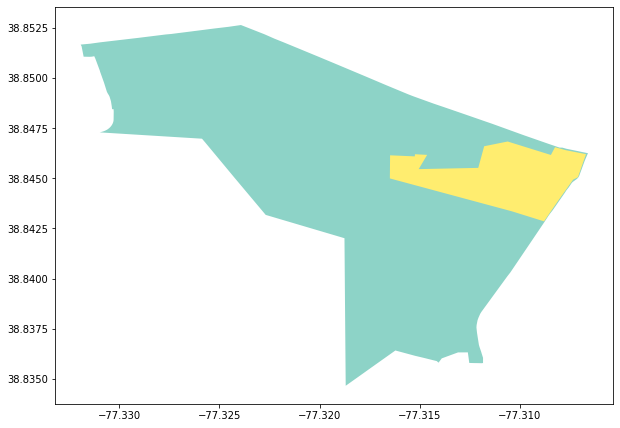

In [14]:
check(va_enclosed, 0, gdf).plot(figsize=(10, 8), cmap="Set3")
#deleteRow(va_enclosed, 3)

In [132]:
tx_enclosed.head()

,State,CName_out,CName_in,x_pos,y_pos
0,tx,tx-angelina-17,tx-angelina-017b,-94.418138,31.158304
1,tx,tx-bexar-1034,tx-bexar-1125c,-98.763426,29.447191
2,tx,tx-bexar-1108,tx-bexar-1073b,-98.731211,29.443516
3,tx,tx-bexar-1121,tx-bexar-1144b,-98.745648,29.475496
4,tx,tx-bexar-1121,tx-bexar-1144c,-98.747597,29.479813


In [133]:
ri_enclosed.head()

,State,CName_out,CName_in,x_pos,y_pos


In [134]:
va_enclosed.head()

,State,CName_out,CName_in,x_pos,y_pos
0,va,va-fairfaxcity-0590,va-fairfax-0652,-77.310981,38.845031
1,va,va-manassascity-1429,va-princewilliamcounty-1849,-77.479223,38.752996
2,va,va-rockingham-2050,va-rockingham-2032,-78.941160,38.417272


In [135]:
tx_enclosed.to_csv("TX_Enclosed_Error.csv", index=False)
va_enclosed.to_csv("VA_Enclosed_Error.csv", index=False)